In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from sklearn.utils import check_consistent_length
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Helper Functions

In [2]:
def accumulate(*arrays):
    accumulated = []
    for a in arrays:
        accum = np.cumsum(a)
        accumulated.append(accum)
    
    # In case it's just a single array pop it out
    if len(accumulated) == 1:
        accumulated = accumulated.pop()
    
    return accumulated

def roc(*arrays, truncate=False):
    # Assumes inputs are observed counts at each decision point on scale
    rates = []
    for a in arrays:
        # accumulate it then calculate it
        accum = accumulate(a)
        frequency = np.array([(x + i / len(accum)) / (max(accum)+1) for i, x in enumerate(accum, start=1)])
        if truncate:
            # trim off the last element
            frequency = frequency[:-1]
        rates.append(frequency)
    
    if len(rates) == 1:
        rates = rates.pop()
    
    return rates

def z_score(*arrays):
    # compute the z score of ROC data
    z_arrays = []
    for a in arrays:
        z_arrays.append(stats.norm.ppf(a))
    
    if len(z_arrays) == 1:
        z_arrays = z_arrays.pop()
    
    return z_arrays

signal, noise = [13,10,12,11,9,1],[4,4,22,35,15,4]
print(f"Original data:\n\tSignal ratings: {signal}\n\tNoise ratings:{noise}\n")
print(f"Accumulated data:\n\t{accumulate(signal, noise)}\n")
print(f"ROC data:\n\t{roc(signal, noise)}\n")
print(f"Z-score of ROC data:\n\t{z_score(roc(signal, noise))}\n")

Original data:
	Signal ratings: [13, 10, 12, 11, 9, 1]
	Noise ratings:[4, 4, 22, 35, 15, 4]

Accumulated data:
	[array([13, 23, 35, 46, 55, 56], dtype=int32), array([ 4,  8, 30, 65, 80, 84], dtype=int32)]

ROC data:
	[array([0.23099415, 0.40935673, 0.62280702, 0.81871345, 0.97953216,
       1.        ]), array([0.04901961, 0.09803922, 0.35882353, 0.77254902, 0.95098039,
       1.        ])]

Z-score of ROC data:
	[[-0.73557677 -0.22920003  0.3128614   0.91047303  2.04418097         inf]
 [-1.65443473 -1.29280523 -0.36160523  0.74726774  1.65443473         inf]]



## Model Functions

In [3]:
def high_threshold(R=None, noise_roc=None):
    # R will become the intercept on the ROC plot
    # noise_roc is optional;
    #    if provided, then it should be roc-ified & truncated with roc(noise, truncate=True)
    if noise_roc is None:
        # theoretical
        noise_roc = np.array([0, 1])
        
    # Enforce numpy array
    noise_roc = np.array(noise_roc)
    
    # Compute threshold x and y
    x = noise_roc
    y = (1 - R) * noise_roc + R
    
    return x, y


def signal_detection(d=None, c=None, signal_var=1):
    if c is None:
        # theoretical
        c = np.linspace(-5, 5, 500)
    # Enforce numpy
    c = np.array(c)
    
    # Compute signal detection x & y with optional unequal variance
    x = stats.norm.cdf(-d / 2 - c) # noise distribution
    y = stats.norm.cdf(d / 2 - c, scale=signal_var) # signal distribution
    
    return x, y


def dual_process(R=None, d=None, c=None):
    if c is None:
        # theoretical
        c = np.linspace(-5, 5, 500)
    # Enforce numpy
    c = np.array(c)
    
    # Compute dual-process (signal detection + high threshold) x & y
    x = stats.norm.cdf(-d / 2 - c)
    y = R + (1 - R) * stats.norm.cdf(d / 2 - c)
    
    return x, y

def strength_estimate(d=None, c=None):
    # E.g. recognition familiarity
    c = np.array(c)
    cut_point = int(np.median(np.arange(0, len(c))))
    return stats.norm.cdf(d / 2 - c[cut_point])

## Optimization Functions

Using SciPy's `optimize.minimize()`, we need to provide an array of variable parameters (e.g. R, d, c1 .... cn), and these must be in array-like form.

[1] Robert R. Sokal and F. James Rohlf. Biometry: The Principles and Practices of Statistics in BiologicalResearch. W.H. Freeman, 3 edition, 1994  
[2] Hoey, J. (2012). [The Two-Way Likelihood Ratio (G) Test and Comparison to Two-Way Chi Squared Test.](https://arxiv.org/pdf/1206.4881.pdf)

In [4]:
def g_test(x, x_freq, expected, x_max):
    # Refs: [1, 2]
    # Two-way log-likelihood G-test
    # Implementation issues:
    #    depending on minimization starting variables, the log expressions can throw errors from negative values and div/0 etc. Numpy just warns and continues.
    a = 2 * x * np.log(x_freq / expected) 
    b = 2 * (x_max - x) * np.log((1 - x_freq) / (1 - expected))
    return a + b

def sum_g_squared(parameters, labels, signal, noise, model='sdt', optimizing=False):
    # Formerly called `detection_model()`
    # parameters: variable parameters to adjust if optimizing. Must be list even if size of 1
    # labels: string names corresponding to each parameters. MUST be of equal size to parameters, also list
    # signal: observed counts at each decision point on scale for SIGNAL PRESENT trials
    # noise: observed counts at each decision point on scale for SIGNAL ABSENT trials
    # model: optional, can be any one of 'ht' (high threshold), 'sdt' (signal detection theory), 'dpsdt' (dual process + signal detection).
    # optimizing: no longer needed optional, default False. When set to true, only the sum of g squared is returned
    
    assert len(parameters)==len(labels), print(f"Length of parameters ({len(parameters)}) does not match length of labels ({len(labels)}).")
    # Ensure parameter and labels are numpy
    parameters = np.array(parameters)
    labels = np.array(labels)
    
    # Get the ROC data and truncate it ready for computing sum of g squared (avoids values of 0 or 1)
    signal_roc, noise_roc = roc(signal, noise, truncate=True)
    # Get the accumulated inputs as well but store the maximum value before truncating.
    signal_acc, noise_acc = accumulate(signal, noise)
    # The maximum value should always be last after the accumulate function is applied, so we just index it.
    signal_acc_max = signal_acc[-1] # extract the maximum
    signal_acc = signal_acc[:-1] # truncate signal_acc
    noise_acc_max = noise_acc[-1]
    noise_acc = noise_acc[:-1]
    
    if model=='ht':
        # High Threshold. labels `variable` MUST contain `R`, with corresponding `parameters` value of R
        if ('R' not in labels):
            raise ValueError(f"`R`not specified in parameter labels. labels specified were: {labels}.")
        R = parameters[labels == 'R'].item()
        noise_expected, signal_expected = high_threshold(R=R, noise_roc=noise_roc)
        
    elif model in ['sdt', 'uvsdt']:
        if 'd' not in labels:
            raise ValueError(f"Either or both of `R` and `d` not specified in parameter labels. labels specified were: {labels}.")
        # Check if signal variance specified, otherwise just keep it at default. determine c parameters
        if 'signal_var' in labels:
            signal_var = parameters[labels == 'signal_var']
            c = parameters[(labels!='R') & (labels!='d') & (labels!='signal_var')]
        else:
            # Explicitly keeping at default var
            signal_var = 1
            c = parameters[(labels!='R') & (labels!='d')]
        d = parameters[labels == 'd'].item()
        noise_expected, signal_expected = signal_detection(d=d, c=c, signal_var=signal_var)
        
    elif model == 'dpsdt':
        if ('R' not in labels) or ('d' not in labels):
            raise ValueError(f"`R` not specified in parameter labels. labels specified were: {labels}.")
        # Grab the R and d values
        R = parameters[labels == 'R'].item()
        d = parameters[labels == 'd'].item()
        
        c = parameters[(labels!='R') & (labels!='d')]
        # Get the expected values for signals and noises
        noise_expected, signal_expected = dual_process(R, d, c)
    
    # compute g squared values for signal and noise data
    signal_g_squared = g_test(x=signal_acc, x_freq=signal_roc, expected=signal_expected, x_max=signal_acc_max)
    noise_g_squared = g_test(x=noise_acc, x_freq=noise_roc, expected=noise_expected, x_max=noise_acc_max)
    
    sum_of_g_squared = np.sum([signal_g_squared, noise_g_squared])
    
    if optimizing:
        return sum_of_g_squared
    else:
        return sum_of_g_squared, noise_expected, signal_expected

def optimize_model(objective, labels, signal, noise, model, iterations=100):

    for i in range(1, int(iterations+1)):    
        if i==1:
            parameters = np.zeros(len(labels)) # if other testing is shit then might need to rethink this
            parameters[labels == 'R'] = 0.99 # Make sure R has a good starting value (if it exists)  
        else:
            parameters[labels!='R'] = np.random.random_sample(len(parameters[labels!='R']))

        # print(f"Starting parameters:\n\t\t{parameters}")
        optimizing = True # requires True to suppress multiple return values from the objective function

        opt = minimize(fun=objective, x0=parameters, args=(labels, signal, noise, model, optimizing), tol=1e-4)
        
        if opt.success:
            break
    
    opt_parameters = opt.x
    status = "successful" if opt.success else "failed"
    print(f"{model} optimization {status} over {i} iterations")
    print(f"{status} starting parameters:{parameters}")
    print(f"{status} final parameters:{opt_parameters}")
    print(f"{status} G\N{SUPERSCRIPT TWO}: {opt.fun}\n")
    
    # Get the labels & values corresponding to NON decision variables i.e. NOT c values
    non_decision_labels = labels[np.isin(labels, ['R', 'd', 'signal_var'])]
    non_decision_parameters = opt_parameters[np.isin(labels, ['R', 'd', 'signal_var'])]
    
    # Get the decision labels and values
    decision_labels = labels[~np.isin(labels, ['R', 'd', 'signal_var'])]
    decision_parameters = opt_parameters[~np.isin(labels, ['R', 'd', 'signal_var'])]
    
    output = {'model':model, 'optimize_result':opt, 
              'data':{'signal':signal,'noise':noise},'minimum':opt.fun, 'labels':labels, 
              'c_vars':decision_parameters, 'c_labels':decision_labels,
             'non_c_vars':{l:p for l, p in zip(non_decision_labels, non_decision_parameters)}}
    
    return output

def get_processes():
    return

In [5]:
# # Example data 1
# signal = [508,224,172,135,119,63] # Signal present examples
# noise = [102,161,288,472,492,308] # Signal absent examples

# # Example data 2
example_2 = {'signal':[431,218,211, 167,119, 69], 'noise':[102,161,288,472,492,308],
             'ht_parameters': np.array([0.459564977806581]),# R
             'ht_labels': np.array(['R']),
             'ht_testing_G': 198.940934458771,
             
             'sdt_parameters':np.array([1.01439006038876, # d
                                        0.958740557949141,
                                        0.48797217624754,
                                        -0.00935955993937299,
                                        -0.614403917274333,
                                        -1.37492636400985]),
             'sdt_labels':np.array(['d', 'c1', 'c2', 'c3', 'c4', 'c5']),
             'sdt_testing_G': 58.6027491579573,
             
             'uvsdt_parameters':np.array([1.30,1.16,1.04,0.48,-0.08,-0.74,-1.53]),
             'uvsdt_labels':np.array(['signal_var', 'd', 'c1','c2','c3','c4','c5']),
             'uvsdt_testing_G':2.633,
             
             'dpsdt_parameters':np.array([0.240020821540452, # R
                                          0.691305735458908, # d
                                          1.28497655282868,
                                          0.687197522357083,
                                          0.134196177689579,
                                          -0.495119831811334,
                                          -1.25674378226952]),
             'dpsdt_labels':np.array(['R', 'd', 'c1', 'c2', 'c3', 'c4', 'c5']),
             'dpsdt_testing_G': 17.4073551151917}



# Example data 3 -----------------------------------------------------#
signal = [13,10,12,11,9,1] # Signal present examples
noise = [4,4,22,35,15,4] # Signal absent examples
example_3 = {'signal':[13,10,12,11,9,1], 'noise':[4,4,22,35,15,4],
             'ht_parameters': np.array([0.290197112447361]),
             'ht_labels': np.array(['R']),
             'ht_testing_G':5.097716096,
             'sdt_parameters':np.array([0.688841386383297, 
                                        1.17690699236133,
                                        0.753893701189727,
                                        0.0233356921180415,
                                        -0.91519735628651,
                                        -1.95591806972918]),
             'sdt_labels':np.array(['d', 'c1', 'c2', 'c3', 'c4', 'c5']),
             'sdt_testing_G':7.70924692362448,
             
             'uvsdt_parameters':np.array([1.39,0.80,1.34,0.83,-0.04,-1.09,-2.15]),
             'uvsdt_labels':np.array(['signal_var', 'd', 'c1','c2','c3','c4','c5']),
             'uvsdt_testing_G':1.922,
             
             'dpsdt_parameters':np.array([0.223677389183856,
                                          0.262320983747282,
                                          1.61202361145935,
                                          1.08632760356576,
                                          0.190627724971991,
                                          -0.794393708266734,
                                          -1.81546835049758]),
             'dpsdt_labels':np.array(['R', 'd', 'c1', 'c2', 'c3', 'c4', 'c5']),
            'dpsdt_testing_G':3.05123502713937}

In [6]:
model = 'uvsdt'
example = example_2

# Testing -----------------
signal = example['signal']
noise = example['noise']

labels = example[f'{model}_labels']
parameters = example[f'{model}_parameters']
testing_g = example[f'{model}_testing_G']

print(f"Testing the {model} model:\n")
print(f"Labels: {labels}")
print(f"Parameters:{parameters}\n")

# Get ROC data and print it to make sure it's right
s, n = roc(signal, noise)
print(f"\tSignal: {s}\n\tNoise: {n}\n")

g, exp_s, exp_n = sum_g_squared(parameters=parameters, labels=labels,
               signal=signal, noise=noise, model=model)
print(f"\tSum G\N{SUPERSCRIPT TWO} = {g} (testing G\N{SUPERSCRIPT TWO} = {testing_g})\n\tExpected signal:{exp_s}\n\tExpected noise:{exp_n}")

Testing the uvsdt model:

Labels: ['signal_var' 'd' 'c1' 'c2' 'c3' 'c4' 'c5']
Parameters:[ 1.3   1.16  1.04  0.48 -0.08 -0.74 -1.53]

	Signal: [0.35457785 0.53399123 0.70764803 0.84512061 0.94311952 1.        ]
	Noise: [0.05601243 0.14437135 0.30235746 0.56122076 0.83104898 1.        ]

	Sum G² = 2.7168429314247975 (testing G² = 2.633)
	Expected signal:[0.05261614 0.1445723  0.30853754 0.56355946 0.82894387]
	Expected noise:[0.36172709 0.53065763 0.69416543 0.84503874 0.94771352]


## Test optimization on selected models

In [7]:
model = 'dpsdt'
example = example_2

# Testing -----------------
signal = example['signal']
noise = example['noise']
print(signal, noise)

labels = example[f'{model}_labels']
# parameters = example[f'{model}_parameters']
# testing_g = example[f'{model}_testing_G']

dpsdt_model = optimize_model(objective=sum_g_squared,labels=labels, signal=signal,noise=noise, model=model)
# ht_model = optimize_model(objective=sum_g_squared,labels=labels, signal=signal,noise=noise, model=model)

[431, 218, 211, 167, 119, 69] [102, 161, 288, 472, 492, 308]
dpsdt optimization successful over 3 iterations
successful starting parameters:[0.99       0.41925543 0.02503125 0.15779912 0.38035799 0.76591426
 0.9466649 ]
successful final parameters:[ 0.24002455  0.69130006  1.28498368  0.68720208  0.13419966 -0.49511592
 -1.2567397 ]
successful G²: 17.40735508453858



In [8]:
print(dpsdt_model['c_vars'])
print(dpsdt_model['non_c_vars'])
dpsdt_model.keys()

[ 1.28498368  0.68720208  0.13419966 -0.49511592 -1.2567397 ]
{'R': 0.24002454995053293, 'd': 0.6913000591509575}


dict_keys(['model', 'optimize_result', 'data', 'minimum', 'labels', 'c_vars', 'c_labels', 'non_c_vars'])

### Run optimization on all models

In [9]:
example = example_2
model_names = ['ht', 'sdt', 'uvsdt', 'dpsdt']

opt_models = {}

for m in model_names:
    opt_model = optimize_model(objective=sum_g_squared,
                               labels=example[m+'_labels'],
                               signal=signal,
                               noise=noise,
                               model=m)
    opt_models[m] = opt_model

ht optimization successful over 1 iterations
successful starting parameters:[0.99]
successful final parameters:[0.45956523]
successful G²: 198.9409344580076

sdt optimization successful over 2 iterations
successful starting parameters:[0.21368968 0.239021   0.1755128  0.27408817 0.6742685  0.40118648]
successful final parameters:[ 1.01439061  0.95874151  0.48797283 -0.00935914 -0.61440324 -1.37492515]
successful G²: 58.602749152103925

uvsdt optimization successful over 22 iterations
successful starting parameters:[0.23996072 0.7993389  0.73141159 0.72965951 0.98775127 0.47561914
 0.78789005]
successful final parameters:[ 1.29998886  1.16450633  1.03713734  0.47598937 -0.08245249 -0.73677083
 -1.52927783]
successful G²: 2.633156515661418

dpsdt optimization successful over 2 iterations
successful starting parameters:[0.99       0.35932007 0.00960968 0.83663729 0.74980164 0.45715541
 0.75746836]
successful final parameters:[ 0.24002454  0.69130008  1.28498367  0.68720208  0.13419965 -0.

In [10]:
m = 'dpsdt'
print(opt_models.keys())
print(opt_models[m].keys())
print(opt_models[m]['minimum'])
print(opt_models[m]['non_c_vars'])
print(opt_models[m]['c_vars']) # the decision variable

dict_keys(['ht', 'sdt', 'uvsdt', 'dpsdt'])
dict_keys(['model', 'optimize_result', 'data', 'minimum', 'labels', 'c_vars', 'c_labels', 'non_c_vars'])
17.40735508453878
{'R': 0.24002454361008255, 'd': 0.6913000799205808}
[ 1.28498367  0.68720208  0.13419965 -0.49511592 -1.25673972]


## Plot Results

In [11]:
# Get model performances as G values
model_performances = pd.Series({m+"_g":opt_models[m]['minimum'] for m in opt_models.keys()}).sort_values(ascending=False)
model_performances

ht_g       198.940934
sdt_g       58.602749
dpsdt_g     17.407355
uvsdt_g      2.633157
dtype: float64

In [12]:
# Get the parameter estimates
recollection = opt_models['dpsdt']['non_c_vars']['R']
d = opt_models['dpsdt']['non_c_vars']['d']
c_vars = opt_models['dpsdt']['c_vars']
familiarity = strength_estimate(d=d, c=c_vars)
print(recollection, familiarity)

parameter_estimates = pd.Series({'recollection':recollection, 'familiarity':familiarity})
print(parameter_estimates)

0.24002454361008255 0.5837320818722935
recollection    0.240025
familiarity     0.583732
dtype: float64


In [13]:
# Get the theoretical data
ht_x, ht_y = high_threshold(opt_models['dpsdt']['non_c_vars']['R'])

sdt_x, sdt_y = signal_detection(d=opt_models['sdt']['non_c_vars']['d'])

uvsdt_x, uvsdt_y = signal_detection(d=opt_models['uvsdt']['non_c_vars']['d'], 
                                    signal_var=opt_models['uvsdt']['non_c_vars']['signal_var'])

dpsdt_x, dpsdt_y = dual_process(R=opt_models['dpsdt']['non_c_vars']['R'],
                                d=opt_models['dpsdt']['non_c_vars']['d'])

Familiarity = 0.5837320818722935
Recollection = 0.24002454361008255


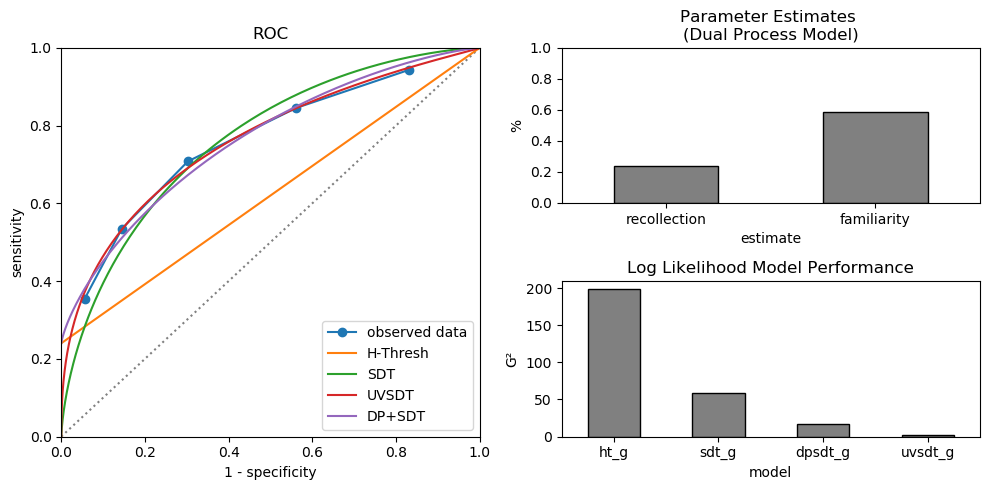

In [14]:
fig = plt.figure(figsize=(10,5), dpi=100)
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(2,2,2)
ax2 = fig.add_subplot(2,2,4)

ax0.plot([0,1], [0,1], c='gray', ls='dotted')

# Plot observed data
ax0.plot(*roc(noise, signal, truncate=True), marker='o', label='observed data')

# plotting models
ax0.plot(ht_x, ht_y, label='H-Thresh')
ax0.plot(sdt_x, sdt_y, label='SDT')
ax0.plot(uvsdt_x, uvsdt_y, label='UVSDT')
ax0.plot(dpsdt_x, dpsdt_y, label='DP+SDT')

ax0.set_ylim(0,1)
ax0.set_xlim(0,1)
ax0.set_xlabel('1 - specificity')
ax0.set_ylabel('sensitivity')
ax0.legend(loc='lower right')
ax0.set_title('ROC')


# Parameter Estimates plot
print(f"Familiarity = {familiarity}\nRecollection = {recollection}")
parameter_estimates.plot(kind='bar', edgecolor='k', rot=0, title='Parameter Estimates \n(Dual Process Model)', color='grey', ax=ax1)
ax1.set_xlabel('estimate')
ax1.set_ylabel('%')
ax1.set_ylim(0,1)


# Model Performance plot
model_performances.plot(kind='bar', edgecolor='k', rot=0, title='Log Likelihood Model Performance', color='gray', ax=ax2)
ax2.set_xlabel('model')
ax2.set_ylabel('G\N{SUPERSCRIPT TWO}')

plt.tight_layout()
plt.show()